# Business Problem
### Apple is hosting a tech conference and they have asked for a machine learning model to determine whether tweets have a positive or negative sentiment when introducing a new product. 

I'm going to start with importing all the necessary libraries as well as a custom helper function that contains three functions. 
- `model_helper` - Helper function to run sklearn models.  
- `word_count_by_class` - Function to count words in positive and negative tweets. 
- `tweet_finder_by_word` - Function to find tweets with specific key word.




In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.patches as mpatches


import string

from nltk.corpus import stopwords
stop = stopwords.words('english')

from helper import model_helper, word_count_by_class, tweet_finder_by_word

# 1. Obtain

Load in data from CrowdFlower and data.world. The dataset contains 3 columns with 9,093 rows. The dataset can be found [here](https://data.world/crowdflower/brands-and-product-emotions)

In [2]:
# load in the dataset
df = pd.read_csv("data/emoting_tweets.csv", encoding_errors="ignore")
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# 2. Scrub + Explore

Here I'm going to look into the dataset to first scrub the data and then explore the data. I'll use .describe and .shape to get an idea of the of the columns and values and their distribution. I'll next check for null values and remove any unnecessary columns. From there, I'll make a graph to view the values of the target variable and change the values to equal either a 1 or a 0. The next steps will include making the tweets all lowercase, removing punctuation, and removing stopwords using the nltk package. 

In [3]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9063,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [4]:
df.shape

(9093, 3)

In [5]:
# check for null values
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [6]:
# drop tweet_text with null value 
df.dropna(subset=['tweet_text'], inplace=True)

In [7]:
# check for duplicates
df[df.duplicated()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
776,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
2232,Marissa Mayer: Google Will Connect the Digital...,NaN,No emotion toward brand or product
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
3950,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
4897,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive emotion
5338,RT @mention GO BEYOND BORDERS! _ {link} _ #ed...,NaN,No emotion toward brand or product
5341,"RT @mention Happy Woman's Day! Make love, not...",NaN,No emotion toward brand or product
5881,RT @mention Google to Launch Major New Social ...,NaN,No emotion toward brand or product


In [8]:
# drop duplicate tweets 
df.drop(df[df.duplicated()].index, inplace=True)

In [9]:
# rename target column
df["target"] = df["is_there_an_emotion_directed_at_a_brand_or_product"]

In [10]:
# drop former target column to clean up dataset
df.drop(columns=["is_there_an_emotion_directed_at_a_brand_or_product"], inplace=True)

In [11]:
# view target column distribution 
df["target"].value_counts(normalize=True)

No emotion toward brand or product    0.592568
Positive emotion                      0.327489
Negative emotion                      0.062741
I can't tell                          0.017201
Name: target, dtype: float64

In [12]:
# drop two unnecessary target variables
df = df[(df["target"] != "No emotion toward brand or product") & (df["target"] != "I can't tell")]

In [13]:
# view target column distribution
df["target"].value_counts(normalize=True)

Positive emotion    0.83922
Negative emotion    0.16078
Name: target, dtype: float64

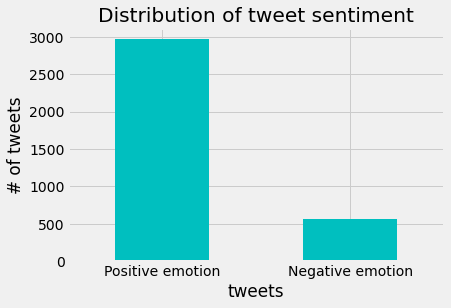

In [14]:
# View distribution of the target values
with plt.style.context('fivethirtyeight'):
    df['target'].value_counts().plot(kind='bar', color = "c")

    # giving title to the plot
    plt.title("Distribution of tweet sentiment")

    # giving X and Y labels
    plt.xlabel("tweets")
    plt.xticks(rotation = 0)
    plt.ylabel("# of tweets")

    plt.show()

In [15]:
# view target column counts
df["target"].value_counts()

Positive emotion    2970
Negative emotion     569
Name: target, dtype: int64

In [16]:
# change "Positive emotion" to equal 1 and "Negative emotion" to equal 0
df["target"] = np.where(df['target'] == "Positive emotion", 1, 0)

In [17]:
# confirm change
df["target"].value_counts()

1    2970
0     569
Name: target, dtype: int64

In [18]:
# set text to lowercase
df['tweet_lowercase'] = df['tweet_text'].map(lambda x: str(x).lower())
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,target,tweet_lowercase
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...


In [19]:
# remove punctuation
no_punctuation = []
for s in df['tweet_lowercase']:
    for p in string.punctuation:
        s = s.replace(p, '')
    no_punctuation.append(s)

In [20]:
# add no_punction column to the dataframe
df['no_punctuation'] = no_punctuation

In [21]:
# view dataframe
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,target,tweet_lowercase,no_punctuation
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,wesley83 i have a 3g iphone after 3 hrs tweeti...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,jessedee know about fludapp awesome ipadiphon...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,swonderlin can not wait for ipad 2 also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,sxsw i hope this years festival isnt as crashy...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...,sxtxstate great stuff on fri sxsw marissa maye...


In [22]:
# remove stop words
df['tweets_without_stopwords'] = df['no_punctuation'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [23]:
# view dataframe
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,target,tweet_lowercase,no_punctuation,tweets_without_stopwords
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,wesley83 i have a 3g iphone after 3 hrs tweeti...,wesley83 3g iphone 3 hrs tweeting riseaustin d...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,jessedee know about fludapp awesome ipadiphon...,jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,swonderlin can not wait for ipad 2 also they s...,swonderlin wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,sxsw i hope this years festival isnt as crashy...,sxsw hope years festival isnt crashy years iph...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...,sxtxstate great stuff on fri sxsw marissa maye...,sxtxstate great stuff fri sxsw marissa mayer g...


Here I'll view the most common words within the tweets_without_stopwords column and make two graphs to view the most common words within positive tweets, and the most common words within negative tweets. 

In [24]:
# view count of most common words within tweets_without_stopwords
df['tweets_without_stopwords'].str.split(expand=True).stack().value_counts()

sxsw          3645
mention       2480
link          1307
ipad          1162
rt            1057
              ... 
owner            1
finals           1
alas             1
overtaken        1
stabilizer       1
Length: 6448, dtype: int64

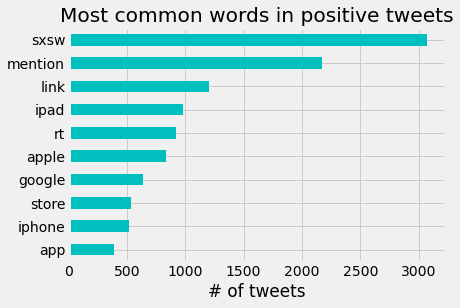

In [25]:
# graph of top 10 words of positive tweets
with plt.style.context('fivethirtyeight'):
    pd.DataFrame(df[df['target'] == 1]['tweets_without_stopwords'].str.split(
            expand=True).stack().value_counts().head(11)).drop("2").plot(kind="barh", color="c", legend=False)
    plt.gca().invert_yaxis()
    plt.xlabel("# of tweets")
    plt.title("Most common words in positive tweets")

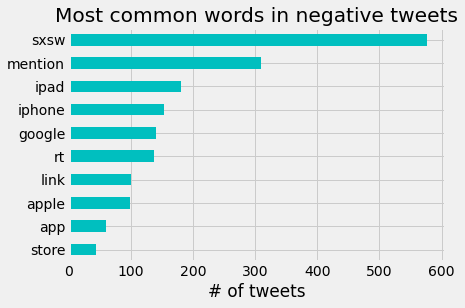

In [26]:
# graph of top 10 words of negative tweets
with plt.style.context('fivethirtyeight'):
    pd.DataFrame(df[df['target'] == 0]['tweets_without_stopwords'].str.split(
            expand=True).stack().value_counts().head(11)).drop("2").plot(kind="barh", color="c", legend=False)
    plt.gca().invert_yaxis()
    plt.xlabel("# of tweets")
    plt.title("Most common words in negative tweets")

# 4. Model

For the modeling portion, I'll split the data with train_test_split and then apply the model_helper function for several iterations of logisitic regression, decision tree classifer, and random forest classifier models. 

#### Train test split

In [27]:
# train test split 
X = df['tweets_without_stopwords']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

## Bag of words model iteration
### Use logistic regression, decision tree classifier, and random forest classifier

In [28]:
lr_basic = model_helper(X, y, LogisticRegression(), bow=True)

Training Score: 0.9866276640200585
Testing Score: 0.9350039154267814


In [29]:
dt_basic = model_helper(X, y, DecisionTreeClassifier(), bow=True)

Training Score: 1.0
Testing Score: 0.9105431309904153


In [30]:
dt_70 = model_helper(X, y, DecisionTreeClassifier(max_depth=70), bow=True)

Training Score: 0.986644407345576
Testing Score: 0.9148766905330151


### * Best model score 🎉

The random forest classifier with bag of words proves to be the best model with the highest f1 score.

In [31]:
rf = model_helper(X, y, RandomForestClassifier(random_state=11), bow=True)

Training Score: 1.0
Testing Score: 0.931888544891641


In [32]:
rf_50 = model_helper(X, y, RandomForestClassifier(max_depth=50, random_state=11), bow=True)

Training Score: 0.940521185597772
Testing Score: 0.9244851258581235


## Bag of words with class_weight="balanced" model iteration
### Use logistic regression, decision tree classifier, and random forest classifier

In [33]:
lr_cw = model_helper(X, y, LogisticRegression(class_weight="balanced"), bow=True)

Training Score: 0.9901877133105803
Testing Score: 0.919315403422983


In [34]:
dt_cw = model_helper(X, y, DecisionTreeClassifier(class_weight="balanced"), bow=True)

Training Score: 1.0
Testing Score: 0.88663282571912


In [35]:
rf_cw = model_helper(X, y, RandomForestClassifier(class_weight="balanced", random_state=11), bow=True)

Training Score: 1.0
Testing Score: 0.9333333333333333


## Tfidf model iteration
### Use logistic regression, decision tree classifier, and random forest classifier

In [36]:
lr_tfidf = model_helper(X, y, LogisticRegression(), bow=False)

Training Score: 0.9230168034388433
Testing Score: 0.9236641221374045


In [37]:
dt_tfidf = model_helper(X, y, DecisionTreeClassifier(), bow=False)

Training Score: 1.0
Testing Score: 0.8987854251012146


In [38]:
rf_tfidf = model_helper(X, y, RandomForestClassifier(random_state=11), bow=False)

Training Score: 1.0
Testing Score: 0.9290123456790124


## Tfidf and class_weight="balanced" model iteration
### Use logistic regression, decision tree classifier, and random forest classifier

In [39]:
lr_tfidf = model_helper(X, y, LogisticRegression(class_weight="balanced"), bow=False)

Training Score: 0.9674337820234477
Testing Score: 0.9063545150501673


In [40]:
dt_tfidf = model_helper(X, y, DecisionTreeClassifier(class_weight="balanced"), bow=False)

Training Score: 1.0
Testing Score: 0.8901639344262294


In [41]:
rf_tfidf = model_helper(X, y, RandomForestClassifier(class_weight="balanced", random_state=11), bow=False)

Training Score: 1.0
Testing Score: 0.9292307692307691


# 5. Interpret

For this section, I'll first make a confusion matrix using my best model, a random forest classifier. This is used to look at the true positives, false positives, true negatives, and false negatives. Then I'll look at the feature importance of the different words. Also, I'll look at whether those words are more common in positive or negative tweets using the function `word-count_by_class`.

In [42]:
# Make confusion matrix
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

C:\Users\Jeff\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


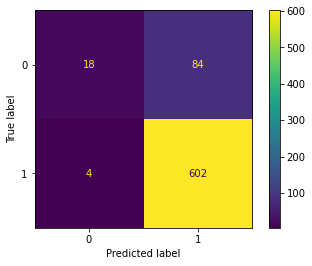

In [43]:
# confusion matrix with best model, random forest
plot_confusion_matrix(rf, X_test_bow, y_test)

In [44]:
# make feature importance plot
feat_importance = pd.DataFrame({"word": vectorizer.get_feature_names_out(), 
                               "importance": rf.feature_importances_})

In [45]:
# view feature importance
fi = feat_importance.sort_values(by="importance", ascending=False).head(10)
fi

,word,importance
2889,link,0.012269
2262,headaches,0.011623
3110,mention,0.010182
1742,fail,0.008376
1768,fascist,0.007710
2610,iphone,0.006667
4243,rt,0.006537
2249,hate,0.006524
1445,doesnt,0.006501
3203,money,0.006033


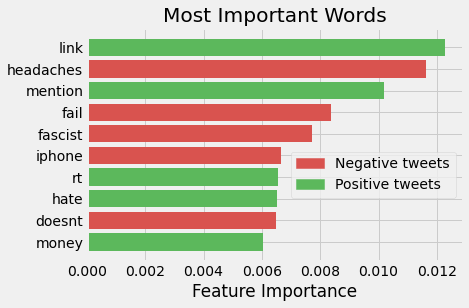

In [46]:
# graph of most important words with the above feature importance plot
with plt.style.context('fivethirtyeight'):
    plt.barh(y=fi["word"], width=fi["importance"], color=['#5cb85c', '#d9534f','#5cb85c','#d9534f', '#d9534f',
                                                          '#d9534f', '#5cb85c', '#5cb85c', '#d9534f',  '#5cb85c' ])
    plt.gca().invert_yaxis()
    
    red_patch = mpatches.Patch(color= '#d9534f', label='Negative tweets')
    green_patch = mpatches.Patch(color= '#5cb85c', label='Positive tweets')

    plt.legend(handles=[red_patch, green_patch], bbox_to_anchor=(1, 0.5))
    plt.xlabel('Feature Importance')
    plt.title('Most Important Words');

In [47]:
# look at target count by keyword function
word_count_by_class("rt", df)

postive count: 920
negative count: 137


I also made a custom function named `tweet_finder_by_word`, this function finds tweets with a given keyword and returns the tweet and whether the tweet was positive or negative. 

In [48]:
# find tweets by keyword function
tweet_finder_by_word("fail", df)

positive - Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1.   #fail
positive - I love my @mention iPhone case from #Sxsw but I can't get my phone out of it #fail
positive - How could I forget my cell phone today for #SXSW what a fail glad I have my iPad #lifelinetotheworld
negative - So we get to see google fail at social on another day RT @mention Okay, no Google Circles debuting at #sxsw today
negative - @mention @mention @mention @mention Paper phones?  Means an iPad will likely be useless at #sxsw as well. #fail
negative - 2+ hour wait at the makeshift Apple store for iPad 2. #fail #sxsw
negative - @mention another google social failure? #sxsw
negative - Stupid technology! You always fail at important times! At #SXSW w/ an iPhone, laptop AND Blackberry and the only thing working is my pen.
positive - Fail Whale artist @mention living through the iPad 2 #sxsw {link}
negative - #sxsw live stream not working on iPad #fail {

# Conclusion

### Using a machine learning model, we can predict whether a tweet is positive or negative. Negative tweets have strongly negative words while positive tweets have less distinctive words that indicate positivity. Below are the final model results:


| Models                   | Bag-of-words | TF-IDF |
|--------------------------|--------------|--------|
| Logistic Regression      | 0.931        | 0.926  |
| Decision Tree Classifier | 0.919        | 0.899  |
| Random Forest Classifier | 0.932        | 0.929  |